In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLKQRRAALKQRIAALKQRRAALKWQIQG', 'GQLKQRRAALKQRIAALKQRRAALKWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['b'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 102.8, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	70   	-861.253	29.0403	-929.343	-809.769
1  	70   	-883.418	24.4567	-947.566	-845.287
2  	78   	-906.426	18.2785	-960.655	-875.339
3  	63   	-917.918	14.1068	-960.655	-894.475
4  	83   	-928.557	10.6765	-960.655	-911.351
5  	66   	-932.158	9.65166	-960.655	-916.774
6  	73   	-940.175	8.11043	-960.655	-928.447
7  	80   	-949.03 	7.17031	-963.003	-936.985
8  	70   	-955.04 	3.85456	-963.905	-945.366
9  	66   	-957.308	2.45996	-963.905	-953.148
10 	75   	-958.892	1.88632	-964.269	-955.247
11 	68   	-959.519	1.5491 	-964.269	-956.791
12 	87   	-960.596	1.1878 	-964.269	-958.817
13 	67   	-960.98 	1.06937	-964.875	-959.259
14 	89   	-961.566	1.093  	-964.875	-959.937
15 	71   	-961.767	1.52031	-971.408	-959.937
16 	80   	-962.642	3.22628	-980.135	-960.142
17 	74   	-964.218	4.65029	-980.135	-960.582
18 	66   	-965.964	5.31434	-980.892	-961.29 
19 	64   	-969.985	6.25638	-980.961	-962.33 
20 	75   	-974.942	5.32284	-981.687	-964.299
21 	65   	

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-982.5182118717447

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

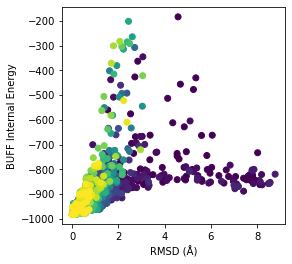

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('apCC-Di-BB_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-850.967	35.2918	-924.121	-686.886
1  	100  	-862.914	26.6586	-924.121	-758.04 
2  	100  	-872.265	26.4968	-930.682	-758.04 
3  	100  	-883.572	23.9911	-930.929	-837.03 
4  	100  	-892.908	22.0735	-935.708	-843.804
5  	100  	-900.104	20.2719	-935.708	-845.018
6  	100  	-909.765	16.7431	-955.403	-864.535
7  	100  	-915.844	14.7369	-955.65 	-877.049
8  	100  	-920.006	14.757 	-955.65 	-877.092
9  	100  	-924.63 	13.0061	-962.172	-897.776
10 	100  	-927.74 	12.8769	-972.147	-900.05 
11 	100  	-929.98 	13.2489	-972.147	-900.05 
12 	100  	-934.795	13.816 	-981.61 	-907.701
13 	100  	-939.49 	14.4377	-981.61 	-911.672
14 	100  	-943.299	13.6731	-981.61 	-915.262
15 	100  	-945.839	13.1013	-981.61 	-915.262
16 	100  	-949.446	12.0534	-981.61 	-920.215
17 	100  	-951.456	11.3377	-981.61 	-928.538
18 	100  	-955.3  	10.7032	-981.61 	-928.72 
19 	100  	-958.253	8.93257	-981.61 	-932.521
20 	100  	-961.43 	8.13908	-981.665	-946.678
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-986.0877619786489

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

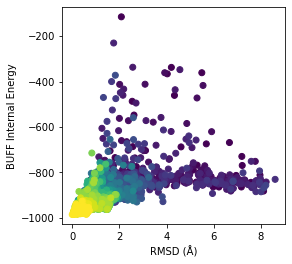

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('apCC-Di-BB_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-747.373	164.028	-917.762	-180.788
1  	80   	-740.073	168.881	-953.84 	-292.101
2  	66   	-765.169	139.569	-957.51 	-197.789
3  	55   	-733.706	173.379	-949.829	-131.221
4  	86   	-826.444	121.818	-923.271	-131.221
5  	90   	-817.345	85.4404	-935.424	-385.854
6  	75   	-766.746	147.593	-956.332	-198.112
7  	64   	-741.654	189.905	-935.739	-162.949
8  	71   	-771.732	173.929	-915.62 	-162.949
9  	69   	-807.805	117.449	-925.118	-188.947
10 	59   	-815.621	93.1809	-912.073	-406.196
11 	71   	-816.111	118.683	-924.968	-126.939
12 	86   	-811.737	129.409	-942.512	-126.939
13 	81   	-769.494	133.886	-929.735	-129.01 
14 	82   	-744.88 	165.064	-916.026	-129.01 
15 	93   	-787.845	139.763	-933.822	36.9813 
16 	94   	-742.213	198.187	-929.953	36.9813 
17 	73   	-763.723	175.379	-939.105	79.0042 
18 	41   	-759.699	174.673	-939.105	79.0042 
19 	62   	-789.625	125.357	-943.042	-236.859
20 	88   	-788.392	129.925	-948.005	-173.261
21 	88   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-958.4033597385603

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

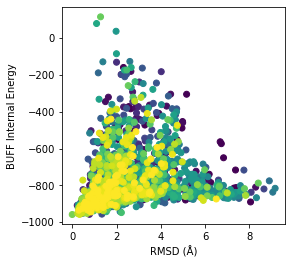

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('apCC-Di-BB_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min    	max    
0  	100  	-815.534	69.4944	-896.46	-490.73
1  	100  	-820.437	82.1556	-927.833	-407.486
2  	100  	-830.365	67.2241	-929.305	-620.26 
3  	100  	-841.975	97.1962	-936.129	-314.154
4  	100  	-862.36 	67.6717	-950.444	-519.744
5  	100  	-884.53 	37.2423	-933.277	-717.254
6  	100  	-897.816	28.8665	-943.622	-759.53 
7  	100  	-908.284	30.0305	-962.638	-819.361
8  	100  	-913.743	31.0581	-975.062	-790.979
9  	100  	-916.269	38.0149	-973.075	-761.611
10 	100  	-929.977	29.6183	-968.447	-799.75 
11 	100  	-938.547	20.9681	-975.449	-813.979
12 	100  	-946.861	12.4545	-972.789	-917.904
13 	100  	-952.191	12.9809	-976.562	-911.244
14 	100  	-952.59 	16.1895	-982.89 	-907.552
15 	100  	-957.522	14.0111	-982.604	-919.539
16 	100  	-962.235	14.1221	-985.035	-919.569
17 	100  	-969.963	11.268 	-984.005	-941.487
18 	100  	-972.927	10.7204	-985.368	-929.137
19 	100  	-975.205	8.96238	-985.992	-942.01 
20 	100  	-978.672	7.69014	-986.009	-952.613
21 	100  	-982

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-986.7494592093219

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

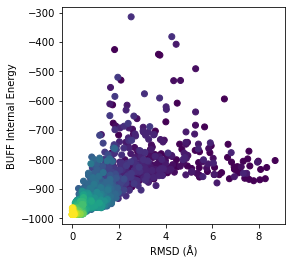

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('apCC-Di-BB_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)